# Ajustement des parametres pour le model national avec categorie d'age

In [1]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook
import datetime

%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

from covid.dataset import get_contact_matrices, fetch_daily_case
from covid.utils import clean_series
from covid.models.examples.covid import COVID19
from covid.models.examples.covid_category import COVID19Category
from covid.policies import contact_matrix_response

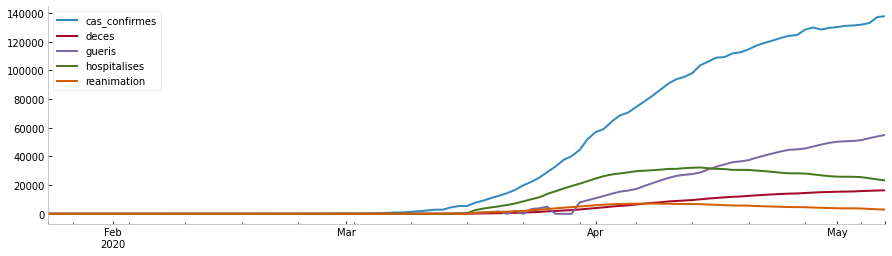

In [2]:
cases = fetch_daily_case(return_data=True)

cases_fr = (
    cases.query("granularite =='pays'")
    .query("source_nom=='Ministère des Solidarités et de la Santé'")
    [["date","cas_confirmes","deces","gueris","hospitalises","reanimation"]]
    .drop_duplicates(subset = ["date"])
    .fillna(0.0)
    .assign(date = lambda x : pd.to_datetime(x["date"]))
    .set_index("date")
)

start,end = cases_fr.index[0],cases_fr.index[-1]
date_range = pd.date_range(start,end,freq="D")
cases_fr = cases_fr.reindex(date_range).fillna(method="ffill")

cases_fr.plot(figsize = (15,4))
plt.show()

cases_fr["Is"] = clean_series(cases_fr["cas_confirmes"] - (cases_fr["deces"] + cases_fr["gueris"]))
cases_fr["D"] = clean_series(cases_fr["deces"])
cases_fr["R"] = clean_series(cases_fr["gueris"])
cases_fr["H"] = clean_series(cases_fr["hospitalises"])
cases_fr["ICU"] = clean_series(cases_fr["reanimation"])


In [3]:
# Population
start_date = datetime.date(2020, 1, 24)
N_young = 17*1e6
N_adult = 36*1e6
N_senior = 15*1e6
N = N_young + N_adult + N_senior

# Lockdown parameters
start_lockdown_date = 53
lockdown_duration = 60
end_lockdown_date = lockdown_duration + start_lockdown_date
ecoles = 0
chezProchesLieuxClos = 0
transport = 0
travailClos = 0.05
autresLieuxClos = 0.05 
ouvert = 0.5

# Prepare model
proba_symptomatic = 0.8

In [4]:
#class COVID19Model(COVID19Category):
#    
#    def __init__(self,params = None):
#        if params is not None:
#            self.reset(params)
#    
#    def reset(self,p):
#        contact = lambda y, t: contact_matrix_response(
#            y, t, start_lockdown_date, end_lockdown_date,
#            {
#                "domicile": p["domicile"],
#                "ecoles":ecoles, 
#                "travailClos": travailClos, 
#                "chezProchesLieuxClos": chezProchesLieuxClos,
#                "autresLieuxClos(resto..)": autresLieuxClos, 
#                "transport": transport, 
#                "ouvert": p["ouvert"]
#            })
#        super().__init__(
#            N=[N_young, N_adult, N_senior],
#            beta=p["beta"],
#            incubation_rate=p["incubation_rate"],
#            recovery_rate_asymptomatic=p["recovery_rate_asymptomatic"],
#            recovery_rate_mild=p["recovery_rate_mild"],
#            hospitalization_rate=p["hospitalization_rate"]*(1-np.array([0, 
#                                                p["proba_icu_adult"], p["proba_icu_senior"]])),
#            proba_symptomatic=np.array([1, 0.8, 0.8]),
#            proba_mild=np.array([0, p["proba_mild_adult"], p["proba_mild_adult"]])*proba_symptomatic ,
#            proba_severe = np.array([0, p["proba_severe_adult"], p["proba_severe_adult"]])*proba_symptomatic,
#            proba_icu = np.array([0, p["proba_icu_adult"], p["proba_icu_senior"]]),
#            hospital_exit_rate = np.array([0, p["hospital_exit_rate_adult"], p["hospital_exit_rate_senior"]]),
#            icu_exit_rate = np.array([0, p["icu_exit_rate_adult"], p["icu_exit_rate_senior"]]),
#            death_hospital_rate = np.array([0, p["death_hospital_rate_adult"], p["death_hospital_rate_senior"]]),
#            death_icu_rate = np.array([0, p["death_icu_rate_adult"], p["death_icu_rate_senior"]]),
#            categories = ["young", "adult", "senior"],
#            contact = contact,
#            offset = p["offset"],
#            symptomatic_isolation=0.75
#        )
#        
class COVID19Model(COVID19Category):
    
    def __init__(self,params = None):
        if params is not None:
            self.reset(params)
    
    def reset(self,p):
        contact = lambda y, t: contact_matrix_response(
            y, t, start_lockdown_date, end_lockdown_date,
            {
                "domicile": p["domicile"],
                "ecoles":ecoles, 
                "travailClos": travailClos, 
                "chezProchesLieuxClos": chezProchesLieuxClos,
                "autresLieuxClos(resto..)": autresLieuxClos, 
                "transport": transport, 
                "ouvert": 0.5
            })
        super().__init__(
            N=[N_young, N_adult, N_senior],
            beta=[p["betay"], p["betaa"],p["betas"]],
            incubation_rate=1/3.7,
            recovery_rate_asymptomatic=1/4.7,
            recovery_rate_mild=1/4.7,
            hospitalization_rate=1/4.7*(1-np.array([0, 0.36, 0.2])),
            proba_symptomatic=np.array([0, 0.5, 0.5]),
            proba_mild=np.array([0, 0.9, 0.4]),
            proba_severe = np.array([0, 0.1, 0.6]),
            proba_icu = np.array([0, 0.36, 0.2]),
            hospital_exit_rate = np.array([0, 0.072, 0.022]),
            icu_exit_rate = np.array([0, 0.05, 0.036]),
            death_hospital_rate = np.array([0, 0.0042, 0.014]),
            death_icu_rate = np.array([0, 0.0074, 0.029]),
            categories = ["young", "adult", "senior"],
            contact = contact,
            offset = p["offset"],
            symptomatic_isolation=0.75
        )

model = COVID19Model({
    "betay": 0.07,
    "betaa": 0.07,
    "betas": 0.07,
    "domicile": 0.1,
    "offset":0
})

In [5]:
def ten_percent(x):
    return (x-x/10, x+x/10)

In [6]:
#space={
#    "ouvert": (0, 0.8),
#    "beta": (0.1, 0.6),
#    "domicile": (0.05, 0.15),
#    "incubation_rate": ten_percent(1/3.7),
#    "recovery_rate_asymptomatic": ten_percent(1/4),
#    "recovery_rate_mild": ten_percent(1/4),
#    "hospitalization_rate": ten_percent(1/4),
#    "proba_mild_adult": ten_percent(0.7),
#    "proba_mild_senior": ten_percent(0.6),
#    "proba_severe_adult": ten_percent(0.1),
#    "proba_severe_senior": ten_percent(0.2),
#    "proba_icu_adult": ten_percent(0.36),
#    "proba_icu_senior": ten_percent(0.2),
#    "hospital_exit_rate_adult": ten_percent(0.072),
#    "hospital_exit_rate_senior": ten_percent(0.022),
#    "icu_exit_rate_adult": ten_percent(0.05),
#    "icu_exit_rate_senior": ten_percent(0.036),
#    "death_hospital_rate_adult": ten_percent(0.0042),
#    "death_hospital_rate_senior": ten_percent(0.0042),
#    "death_icu_rate_adult": ten_percent(0.0074),
#    "death_icu_rate_senior": ten_percent(0.029),
#    "offset": (-20, 20)
#}

space={
    "betay": (0.05, 0.1),
    "betaa": (0.05, 0.1),
    "betas": (0.05, 0.1),
    "domicile": (0.05, 0.15),
    "offset": (-20, 20)
}

In [7]:
init_state = {"S_young":N_young, "S_adult": N_adult-1,
              "S_senior": N_senior, "E_young":0.0, "E_adult": 1.0, "E_old": 0.0}
model.fit(cases_fr[["D", "ICU"]], space, 
          init_state,
          200)


... Found best solution {'betay': 0.07347869267503727, 'betaa': 0.050050191561315995, 'betas': 0.08130375759266316, 'domicile': 0.11695243943400782, 'offset': 5.1161792725128} for value 0.11021509487378095
... Parameters saved in yaml file calibration_params_1588934023.yaml


                       D             H          ICU
2020-01-24      0.000000      2.761431     0.000000
2020-01-25      0.000000      2.964385     1.000000
2020-01-26      0.000000      3.219604     1.000000
2020-01-27      0.000000      3.587068     1.000000
2020-01-28      1.000000      4.106779     1.000000
...                  ...           ...          ...
2020-05-03  15672.791938  25572.551048  3728.468954
2020-05-04  15845.586172  25166.326407  3577.228060
2020-05-05  16027.824629  24647.765091  3395.197218
2020-05-06  16212.468690  24053.173393  3198.565957
2020-05-07  16397.412948  23436.204414  3006.048138

[105 rows x 3 columns] {'S_young': 17000000.0, 'S_adult': 35999999.0, 'S_senior': 15000000.0, 'E_young': 0.0, 'E_adult': 1.0, 'E_old': 0.0} 20


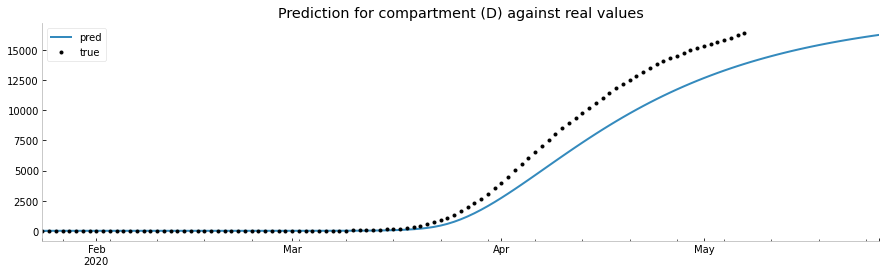

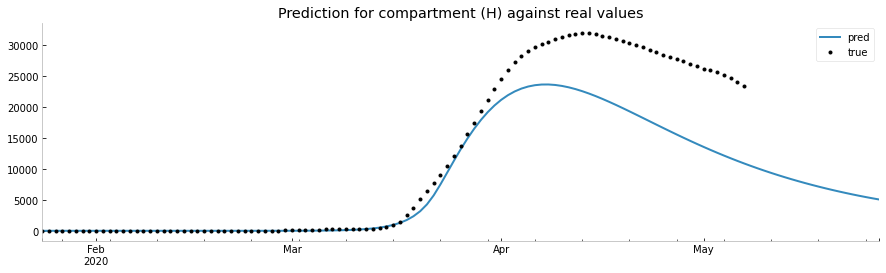

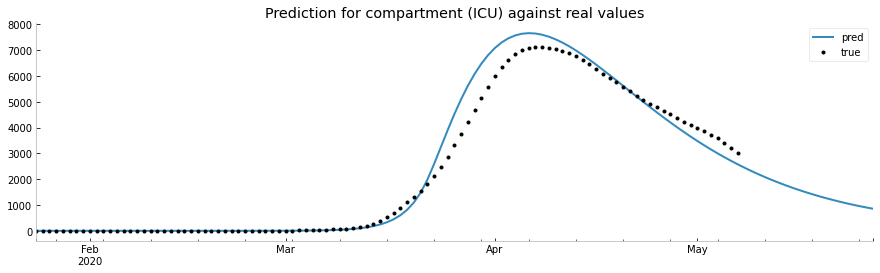

In [8]:
model.show_prediction(cases_fr[["D","H","ICU"]],init_state,forecast_days = 20)